In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy 
import theano
from sklearn.metrics import mean_squared_error
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
from random import seed
import scipy.optimize as opt
plt.style.use("seaborn-darkgrid")
from pymc3.distributions.timeseries import EulerMaruyama

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import datetime
import pandas as pd
import plotly.express as px
import scipy 
px.defaults.height=600

In [3]:
# From now on we'll work with proportions instead of integer numbers
# i -> infectados/N
# Parameters: 
# beta = disease transmission rate
# gamma = recovery rate
# mu = mortality rate
# mu + beta = renewal rate
# theta = [beta - (mu+gamma), beta]
# Thus, if theta[0]<0, the disease will vanish and if theta[0]>0 we have persistence of the disease

i0 = 0.2 # initial proportion of infected
Tf = 20 # Terminal time
T0 = 0 # Initial time
Dt = 0.25 # time step
beta, gamma, mu, sigma = 0.7, 0.4, 0.65,0.005
theta= np.asarray([beta - (mu+gamma), beta,sigma])
theta_t=theta

In [4]:
times = np.arange(T0, Tf, Dt) # time vector
times

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  ,
       11.25, 11.5 , 11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25,
       13.5 , 13.75, 14.  , 14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 ,
       15.75, 16.  , 16.25, 16.5 , 16.75, 17.  , 17.25, 17.5 , 17.75,
       18.  , 18.25, 18.5 , 18.75, 19.  , 19.25, 19.5 , 19.75])

$$     \frac{dI_{t}}{dt} =I_t([\beta N-\mu-\gamma-\beta I_t]dt + \sigma (N-I_t)dB_t) $$

$$ \frac{dI_{t}}{dt} = \left[I_t \left((\beta -\mu -\gamma) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( I_t - \frac{I_t^2}{N}\right) dB_t $$
$$ \frac{dI_{t}}{Ndt} = \left[\frac{I_t}{N} \left((\beta -\mu -\gamma) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( \frac{I_t}{N} - \frac{I_t^2}{N^2}\right) dB_t $$
$$ \frac{dI_{t}}{Ndt} = \left[\frac{I_t}{N} \left((\beta -(\mu +\gamma)) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( \frac{I_t}{N} - \frac{I_t^2}{N^2}\right) dB_t $$

In [5]:
# ODEs model
def SISS(i, t, theta):
    di = (i[0]*(theta[0]-theta[1]*i[0])) + (theta[2] *( i[0]-i[0]**2))
    return di

In [6]:
# Create true ODE solution
infected_t = odeint(SISS, t=times, y0=i0, args=(theta,), rtol=1e-8)
infected_t=infected_t.tolist()
# Simulate observations (true data+log-normal noise with parameter sigma=0.5 in this case)
infected_obs = np.random.lognormal(mean=np.log(infected_t[1:]), sigma=0.25)
infected_obs=infected_obs.tolist()
# we add initial condition after because we now the exact initial condition (it doesn't have noise)
infected_obs=np.insert(infected_obs,0,i0,axis=0)

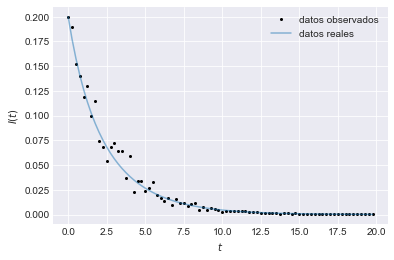

In [7]:
# Plot observations and true data
plt.plot(times, infected_obs, marker="o", linestyle="none", color='k', markersize=2, label=f"datos observados")
plt.plot(times, infected_t, color="C0", alpha=0.5,  label=f"datos reales")
plt.xlabel("$t$")
plt.ylabel("$I(t)$")
plt.legend()
plt.show()

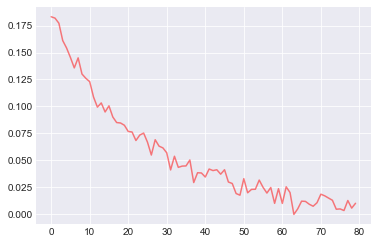

In [8]:
# time series

N = len(times)
x = i0
x_t = []
dt = 1e-1

# simulate
for i in range(N):
    x = x + (x*(theta[0]-(x*theta[1])))*dt + theta[2] * (x-x**2) * np.random.randn()
    x_t.append(x)
x_t = np.array(x_t)

z_t = []
z_t = x_t + np.random.randn(len(x_t)) * 5e-3
plt.plot(z_t, "r", label="$z(t)$", alpha=0.5)

In [9]:
# ODEs model
def SISS(i, theta):
    di = (i[0]*(theta[0]-theta[1]*i[0])) 
    return di, sigma

In [10]:
# Define pymc model and sampling the MC Markov chain
nb_chains = 2 #choose >1 to run some convergence diagnostics on the chains
len_chains = 3000
len_burning_states = 1000
dt = 1e-1

with pm.Model() as model:
    theta = [0,0]
    theta[0] = pm.Cauchy("beta-(mu+gamma)", -2,1) 
    theta[1] = pm.Normal("beta",0,1) 

    eu = EulerMaruyama("EM", dt, SISS, (theta,), shape=x_t.shape, testval=x_t)
    sigma = pm.Normal("sigma", mu=eu, sigma=theta_t[2], observed=z_t)

In [11]:
with model:
    trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains)
    data = az.from_pymc3(trace=trace)

C:\Users\sebas\AppData\Local\Temp\ipykernel_11300\2155683141.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [EM, beta, beta-(mu+gamma)]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 76 seconds.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


In [12]:
a=az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


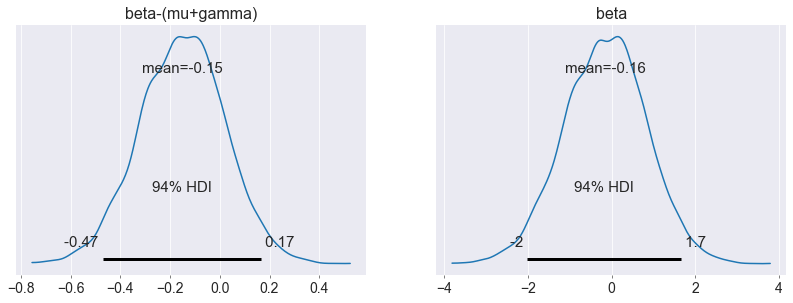

In [13]:
# Plot posterior densities
az.plot_posterior(data, 
                  var_names=["beta-(mu+gamma)", "beta"]);
plt.show()

Text(0, 0.5, 'MCMC promedio')

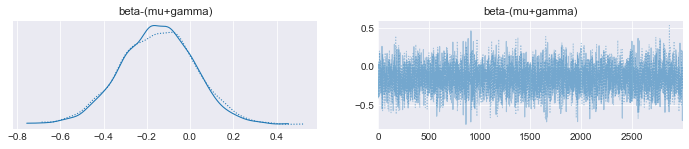

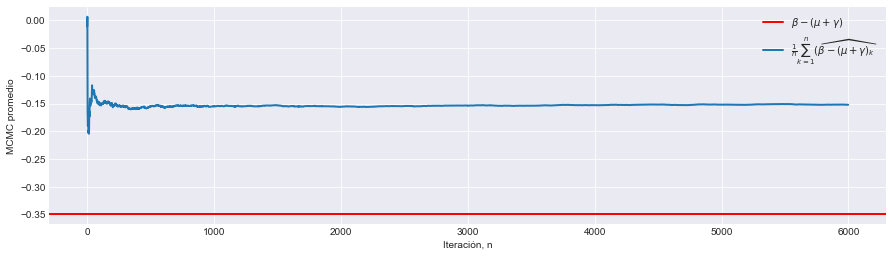

In [14]:
# plot the exploration for each chain and convergence of the ergodic mean
# beta - (mu+gamma)
az.plot_trace({"beta-(mu+gamma)": trace.get_values(varname="beta-(mu+gamma)", combine=False)})
mean_theta0 = [np.mean(trace['beta-(mu+gamma)'][:i]) for i in np.arange(1, len(trace['beta-(mu+gamma)']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[0]], lw=2, color="red", label=r"$\beta-(\mu+\gamma)$")
plt.plot(mean_theta0, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{(\beta-(\mu+\gamma)}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

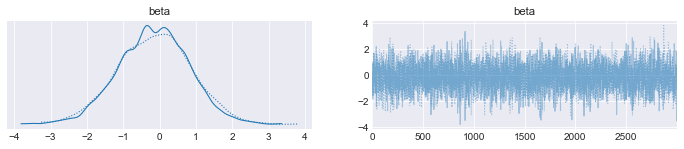

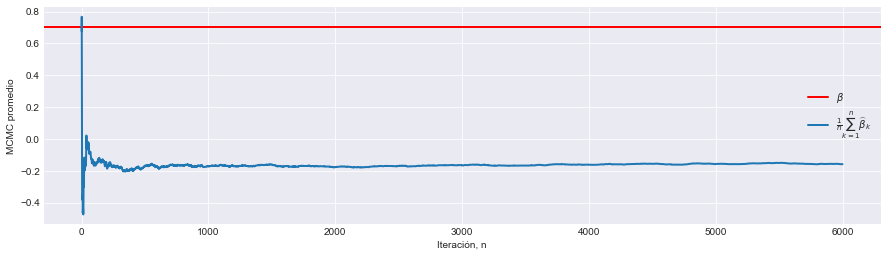

In [15]:
# beta
az.plot_trace({"beta": trace.get_values(varname="beta", combine=False)})
mean_theta1 = [np.mean(trace['beta'][:i]) for i in np.arange(1, len(trace['beta']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[1]], lw=2, color="red", label=r"$\beta$")
plt.plot(mean_theta1, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\beta}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

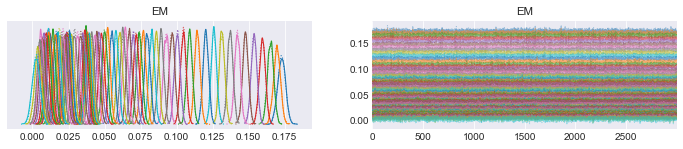

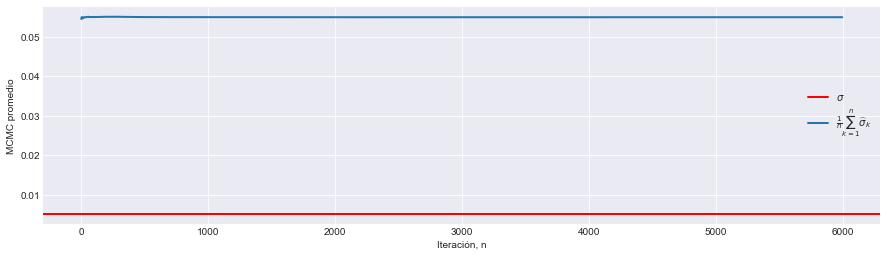

In [16]:
# sigma
az.plot_trace({"EM": trace.get_values(varname="EM", combine=False)})
mean_theta1 = [np.mean(trace['EM'][:i]) for i in np.arange(1, len(trace['EM']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[2]], lw=2, color="red", label=r"$\sigma$")
plt.plot(mean_theta1, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\sigma}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

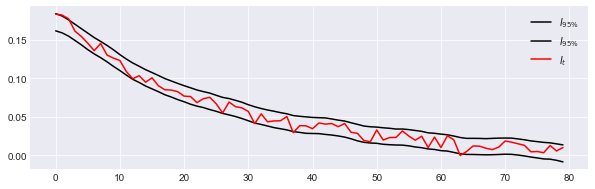

In [17]:
# generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, model=model)

# plot with data
plt.figure(figsize=(10, 3))
plt.plot(np.percentile(ppc_trace["sigma"], [2.5, 97.5], axis=0).T, "k", label=r"$I_{95\%}$")
plt.plot(z_t, "r", label=r"$I_t$")
plt.legend()

In [20]:
with model:
    ppc = pm.sample_posterior_predictive(trace,samples=1000)

c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<AxesSubplot:xlabel='sigma / sigma'>

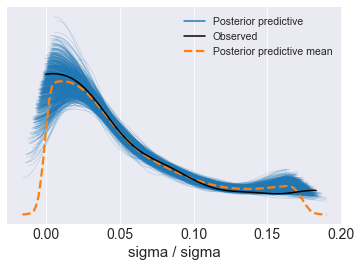

In [21]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

In [22]:
az.summary(ppc)

c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\base.py:220: UserWarning: More chains (1000) than draws (80). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.055,0.047,-0.003,0.155,0.001,0.001,1793.0,18303.0,1.61


c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\base.py:220: UserWarning: More chains (1000) than draws (80). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


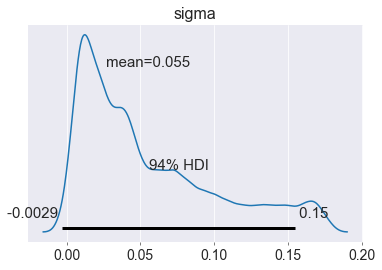

In [23]:
az.plot_posterior(ppc);
plt.show()